# ライブラリ

In [189]:
# ライブラリインポート
import pandas as pd
from scipy import stats
import random
import numpy as np

# warningsを表示しない
import warnings
warnings.filterwarnings("ignore")

# RCTデータからバイアスのあるデータを作成

In [190]:
# データ読み込み
email_data = pd.read_csv("http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")
#email_data.head()

# 女性向けのメールが配信されたデータを削除する
male_df = email_data[email_data["segment"] != "Womens E-Mail"]

# 介入を表すtreatment変数を追加
male_df["treatment"] = male_df["segment"].apply(lambda x: 1 if x == "Mens E-Mail" else 0)
#male_df

# シード
random.seed(0)

# 条件に反応するサンプルの量を半分にする
obs_rate_c = 0.5
obs_rate_t = 0.5

# male_dfに列obs_rate_cとobs_rate_tを作成
conditions = [(male_df["history"] > 300) | (male_df["recency"] < 6) | (male_df["channel"] == "Multichannel")]
male_df["obs_rate_c"] = np.select(conditions, [obs_rate_c], default = 1)
male_df["obs_rate_t"] = np.select(conditions, [1], default = obs_rate_t)
#male_df.head()

# バイアスのあるデータを作成
random_number = np.random.rand(len(male_df))
biased_data = male_df[((male_df["treatment"] == 0) & (random_number < male_df["obs_rate_c"])) | ((male_df["treatment"] == 1) & (random_number < male_df["obs_rate_t"]))]
biased_data

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,obs_rate_c,obs_rate_t
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0,0.5,1.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1,0.5,1.0
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1,0.5,1.0
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1,0.5,1.0
14,4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0.0,0,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63994,7,1) $0 - $100,86.46,0,1,Urban,0,Web,Mens E-Mail,0,0,0.0,1,1.0,0.5
63995,10,2) $100 - $200,105.54,1,0,Urban,0,Web,Mens E-Mail,0,0,0.0,1,1.0,0.5
63996,5,1) $0 - $100,38.91,0,1,Urban,1,Phone,Mens E-Mail,0,0,0.0,1,0.5,1.0
63997,6,1) $0 - $100,29.99,1,0,Urban,1,Phone,Mens E-Mail,0,0,0.0,1,1.0,0.5


# 2.1 回帰分析の導入

## 2.1.5 メールマーケティングデータの分析（回帰編）

### sklearnを使用

In [191]:
# ライブラリ
from sklearn.linear_model import LinearRegression

In [192]:
# 被説明変数＆説明変数
exp_var = ["treatment", "history"]
x = biased_data[exp_var]
y = biased_data[["spend"]]

# spendをtreatmentとhistoryに回帰
biased_reg = LinearRegression()
biased_reg.fit(x, y)

LinearRegression()

In [193]:
# 係数推定値
print("Coefficients", biased_reg.coef_)
print("Intercept", biased_reg.intercept_)

Coefficients [[0.69394238 0.00134942]]
Intercept [0.42877593]


### statsmodelsを使用

In [194]:
# ライブラリ
import statsmodels.api as sm

In [195]:
# 被説明変数＆説明変数
Y = biased_data[["spend"]]
exp_var = ["treatment", "history"]
x = biased_data[exp_var]

# 説明変数行列に定数項を追加
X = sm.add_constant(x)

In [196]:
# 重回帰分析
model = sm.OLS(Y, X)
biased_reg = model.fit()

# 結果を確認：係数推定値のみ
print(biased_reg.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4288      0.147      2.912      0.004       0.140       0.717
treatment      0.6939      0.178      3.891      0.000       0.344       1.043
history        0.0013      0.000      3.926      0.000       0.001       0.002


# 2.2 回帰分析におけるバイアス

## 2.2.1 共変量の追加による効果への作用

In [197]:
# RCTデータでの単回帰
y_rct = male_df[["spend"]]
x_rct = sm.add_constant(male_df[["treatment"]])
model_rct = sm.OLS(y_rct, x_rct)
rct_reg = model_rct.fit()
print(rct_reg.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6528      0.103      6.356      0.000       0.451       0.854
treatment      0.7698      0.145      5.300      0.000       0.485       1.055


In [198]:
# バイアスのあるデータでの単回帰
y_nonrct = biased_data[["spend"]]
x_nonrct = sm.add_constant(biased_data[["treatment"]])
model_nonrct = sm.OLS(y_nonrct, x_nonrct)
nonrct_reg = model_nonrct.fit()
print(nonrct_reg.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7051      0.129      5.450      0.000       0.452       0.959
treatment      0.7906      0.177      4.475      0.000       0.444       1.137


In [199]:
# バイアスのあるデータでの重回帰

# channelをダミー変数に変換
biased_data = pd.get_dummies(biased_data, columns = ["channel"], drop_first = True)

y_nonrct_mreg = biased_data[["spend"]]
x_nonrct_mreg = sm.add_constant(biased_data[["treatment", "recency", "channel_Phone", "channel_Web", "history"]])

model_nonrct_mreg = sm.OLS(y_nonrct_mreg, x_nonrct_mreg)
nonrct_mreg = model_nonrct_mreg.fit()
print(nonrct_mreg.summary().tables[1])

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8929      0.385      2.322      0.020       0.139       1.647
treatment         0.5854      0.183      3.207      0.001       0.228       0.943
recency          -0.0763      0.027     -2.875      0.004      -0.128      -0.024
channel_Phone     0.0191      0.309      0.062      0.951      -0.586       0.625
channel_Web       0.1523      0.309      0.493      0.622      -0.453       0.757
history           0.0012      0.000      3.051      0.002       0.000       0.002


## 2.2.3 RによるOVBの確認

In [200]:
# モデルA
y_A = biased_data[["spend"]]
x_A = sm.add_constant(biased_data[["treatment", "recency", "channel_Phone", "channel_Web"]])
mod_A = sm.OLS(y_A, x_A)
mod_A_reg = mod_A.fit()
print(mod_A_reg.summary().tables[1])

# α1を取得
alpha1 = mod_A_reg.params[1]

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.5644      0.315      4.960      0.000       0.946       2.183
treatment         0.6205      0.182      3.406      0.001       0.263       0.978
recency          -0.0929      0.026     -3.576      0.000      -0.144      -0.042
channel_Phone    -0.3342      0.286     -1.167      0.243      -0.896       0.227
channel_Web      -0.2026      0.286     -0.708      0.479      -0.763       0.358


In [201]:
# モデルB
y_B = biased_data[["spend"]]
x_B = sm.add_constant(biased_data[["treatment", "recency", "channel_Phone", "channel_Web", "history"]])
mod_B = sm.OLS(y_B, x_B)
mod_B_reg = mod_B.fit()
print(mod_B_reg.summary().tables[1])

# β1，β4を取得
beta1 = mod_B_reg.params[1]
beta4 = mod_B_reg.params[5]

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.8929      0.385      2.322      0.020       0.139       1.647
treatment         0.5854      0.183      3.207      0.001       0.228       0.943
recency          -0.0763      0.027     -2.875      0.004      -0.128      -0.024
channel_Phone     0.0191      0.309      0.062      0.951      -0.586       0.625
channel_Web       0.1523      0.309      0.493      0.622      -0.453       0.757
history           0.0012      0.000      3.051      0.002       0.000       0.002


In [202]:
# モデルC
y_C = biased_data[["history"]]
x_C = sm.add_constant(biased_data[["treatment", "recency", "channel_Phone", "channel_Web"]])
mod_C = sm.OLS(y_C, x_C)
mod_C_reg = mod_C.fit()
print(mod_C_reg.summary().tables[1])

# γ1を取得
gamma1 = mod_C_reg.params[1]

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           573.8726      4.610    124.496      0.000     564.838     582.907
treatment        29.9817      2.662     11.262      0.000      24.764      35.200
recency         -14.1787      0.379    -37.370      0.000     -14.922     -13.435
channel_Phone  -301.9353      4.186    -72.133      0.000    -310.140    -293.731
channel_Web    -303.2896      4.179    -72.568      0.000    -311.481    -295.098


In [203]:
# OVBの確認
print("Coef gap:", alpha1 - beta1)
print("OVB:", gamma1 * beta4)

Coef gap: 0.03508501233923189
OVB: 0.03508501233923849


## 2.2.7 Post treatment bias

In [204]:
# treatmentとvisitの相関
y = biased_data[["treatment"]]
x = sm.add_constant(biased_data[["visit", "channel_Phone", "channel_Web", "recency", "history"]])
mod = sm.OLS(y, x)
cor_visit_treatment = mod.fit()
print(cor_visit_treatment.summary().tables[1])

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.7047      0.011     63.499      0.000       0.683       0.726
visit             0.1523      0.008     20.004      0.000       0.137       0.167
channel_Phone    -0.0631      0.009     -6.699      0.000      -0.082      -0.045
channel_Web      -0.0597      0.009     -6.342      0.000      -0.078      -0.041
recency          -0.0291      0.001    -36.562      0.000      -0.031      -0.027
history           0.0001   1.17e-05     10.339      0.000     9.8e-05       0.000


In [205]:
# visitを入れた回帰分析を実行
y = biased_data[["spend"]]
x = sm.add_constant(biased_data[["treatment", "channel_Phone", "channel_Web", "recency", "history", "visit"]])
mod = sm.OLS(y, x)
bad_control_reg = mod.fit()
print(bad_control_reg.summary().tables[1])

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0730      0.380     -0.192      0.848      -0.819       0.673
treatment        -0.0291      0.181     -0.161      0.872      -0.384       0.326
channel_Phone     0.1551      0.305      0.509      0.611      -0.442       0.752
channel_Web       0.0451      0.304      0.148      0.882      -0.551       0.642
recency          -0.0274      0.026     -1.047      0.295      -0.079       0.024
history           0.0007      0.000      1.808      0.071   -5.74e-05       0.001
visit             7.5356      0.247     30.458      0.000       7.051       8.020


# 2.3 回帰分析を利用した探索的な効果検証

## 2.3.2 Rによる回帰分析の実行

- [参考]「「効果検証入門」をPythonで書いた」https://qiita.com/nekoumei/items/648726e89d05cba6f432


In [206]:
# ライブラリ
!pip install rdata
import rdata

# Google Driveをマウント
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [207]:
# データ読み込み
parsed = rdata.parser.parse_file("/content/drive/MyDrive/Colab Notebooks/効果検証入門/vouchers.rda")
converted = rdata.conversion.convert(parsed)
vouchers = converted['vouchers']
vouchers.head()

,ID,BOG95SMP,BOG97SMP,JAM93SMP,SEX,AGE,AGE2,HSVISIT,SCYFNSH,INSCHL,PRSCH_C,PRSCHA_1,PRSCHA_2,VOUCH0,BOG95ASD,BOG97ASD,JAM93ASD,DBOGOTA,DJAMUNDI,D1995,D1997,RESPONSE,TEST_TAK,SEX_NAME,SVY,D1993,PHONE,DAREA1,DAREA2,DAREA3,DAREA4,DAREA5,DAREA6,DAREA7,DAREA8,DAREA9,DAREA10,DAREA11,DAREA12,DAREA13,...,DMONTH4,DMONTH5,DMONTH6,DMONTH7,DMONTH8,DMONTH9,DMONTH10,DMONTH11,DMONTH12,BOG95,BOG97,MOM_SCH,MOM_AGE,MOM_MW,DAD_SCH,DAD_AGE,DAD_MW,SEX2,STRATA1,STRATA2,STRATA3,STRATA4,STRATA5,STRATA6,STRATAMS,REPT6,TOTSCYRS,HASCHILD,MARRIED,WORKING,REPT,NREPT,FINISH6,FINISH7,FINISH8,SEX_MISS,USNGSCH,HOURSUM,TAB3SMPL,WORKING3
1,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,1.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0.0,0.0,0.0,1.0,NaN,12.0,NaN,5.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,0.0,0.0,0.0,0.0,NaN,13.0,NaN,5.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,1.0,0.0,0.0,0.0,14.0,12.0,0.0,8.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,45.0,0.0,2.0,45.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
5,4.0,1.0,0.0,0.0,1.0,14.0,12.0,0.0,8.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,36.0,0.0,11.0,43.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [208]:
# 回帰式で使う文字列の準備
formula_x_base = ["VOUCH0"]
formula_x_covariate = ["SVY",  "HSVISIT", "DMONTH1", "DMONTH2", "DMONTH3", "DMONTH4", "DMONTH5", "DMONTH6", "DMONTH7", "DMONTH8", "DMONTH9", "DMONTH10", "DMONTH11", "DMONTH12", 
                       "AGE", "SEX2", "STRATA1", "STRATA2", "STRATA3", "STRATA4", "STRATA5", "STRATA6", "STRATAMS", "D1993", "D1995", "D1997"]
formula_y = ["TOTSCYRS", "INSCHL", "PRSCH_C", "USNGSCH", "PRSCHA_1", "FINISH6", "FINISH7", "FINISH8", "REPT6", "REPT", "NREPT", "MARRIED", "HASCHILD", "HOURSUM", "WORKING3"]

In [209]:
# 与えられたデータ，被説明変数，説明変数を用いて回帰を実行し，VOUCH0の係数推定値等を返す関数
def get_VOUCH0_regression_summary(df, formula_x_base = None, formula_x_covariate = None, formula_y = None):

  # 被説明変数
  y = df[formula_y]

  # 説明変数
  if formula_x_covariate == None:
    X = df[formula_x_base] # 共変量を含まない場合
  else:
    X = df[formula_x_base + formula_x_covariate] # 共変量を含む場合
  
  # 定数項追加
  X = sm.add_constant(X)

  # 回帰実行
  results = sm.OLS(y, X).fit()

  # 推定結果（係数推定値，t値，p値等）を取得
  summary = results.summary().tables[1]

  # statsmodelsのsummary objectをDataFrameに変換
  summary = pd.read_html(summary.as_html(), header = 0, index_col = 0)[0]

  # summaryからVOUCH0の行を取得
  VOUCH0_summary = summary.loc["VOUCH0", :]

  # 推定結果に名前を付ける（被説明変数名＋"_base" or 被説明変数名＋"_covariate"）
  if formula_x_covariate == None:
    VOUCH0_summary.name = formula_y + "_base"
  else:
    VOUCH0_summary.name = formula_y + "_covariate"
  
  # 推定結果を返す
  return VOUCH0_summary

In [210]:
# bogota 1995のデータを抽出
regression_data = vouchers[(vouchers["TAB3SMPL"] == 1) & (vouchers["BOG95SMP"] == 1)]

In [211]:
# まとめて回帰分析を実行

# 各推定結果を格納するリストを用意
regression_results = []

# 被説明変数ごとに回帰を繰り返す
for y in formula_y:

  # 共変量を含まない場合
  regression_results.append(get_VOUCH0_regression_summary(regression_data, formula_x_base = formula_x_base, formula_x_covariate = None, formula_y = y))

  # 共変量を含む場合
  regression_results.append(get_VOUCH0_regression_summary(regression_data, formula_x_base = formula_x_base, formula_x_covariate = formula_x_covariate, formula_y = y))

# regression_resultsを整形：行にモデル，列に係数推定値，標準誤差，t値，p値，信頼区間を並べる
regression_results = pd.concat(regression_results, axis = 1).T
regression_results.head()

,coef,std err,t,P>|t|,[0.025,0.975]
TOTSCYRS_base,0.0581,0.052,1.110,0.267,-0.045,0.161
TOTSCYRS_covariate,0.0337,0.051,0.661,0.509,-0.066,0.134
INSCHL_base,0.0186,0.022,0.860,0.390,-0.024,0.061
INSCHL_covariate,0.0069,0.020,0.340,0.734,-0.033,0.047
PRSCH_C_base,0.1600,0.028,5.655,0.000,0.104,0.216


## 2.3.3 私立学校への通学と割引券の利用についての分析

In [212]:
# PRSCHA_1とUSNGSCHに対する回帰分析の結果
# regression_resultsからPRSCHA_1_base, PRSCHA_1_covariate, USNGSCH_base, USNGSCH_covariateの行のみ抽出
regression_results.loc[regression_results.index.str.contains("PRSCHA_1|USNGSCH")]

,coef,std err,t,P>|t|,[0.025,0.975]
USNGSCH_base,0.5089,0.023,22.107,0.000,0.464,0.554
USNGSCH_covariate,0.5042,0.023,22.007,0.000,0.459,0.549
PRSCHA_1_base,0.0629,0.017,3.731,0.000,0.030,0.096
PRSCHA_1_covariate,0.0574,0.017,3.385,0.001,0.024,0.091


In [213]:
# [確認] 当選/落選グループごとの6年生開始時における私立学校在籍割合
regression_data.groupby("VOUCH0")["PRSCHA_1"].mean()

VOUCH0
0.0    0.877224
1.0    0.940171
Name: PRSCHA_1, dtype: float64

In [214]:
# 当選/落選グループごとの奨学金利用率
regression_data.groupby("VOUCH0")["USNGSCH"].mean()

VOUCH0
0.0    0.056940
1.0    0.565812
Name: USNGSCH, dtype: float64

## 2.3.4 割引券は留年を減らしているか？

In [257]:
# ライブラリ
import matplotlib.pyplot as plt
import matplotlib as mpl
!pip install japanize-matplotlib
import japanize_matplotlib

In [216]:
# regression_resultsから留年や進級に関するモデルの推定結果を抽出
regression_results_234 = regression_results.loc[["FINISH6_covariate", "FINISH7_covariate", "FINISH8_covariate", "INSCHL_covariate", "NREPT_covariate", "PRSCH_C_covariate", "REPT_covariate", "REPT6_covariate"]]
regression_results_234

,coef,std err,t,P>|t|,[0.025,0.975]
FINISH6_covariate,0.0229,0.012,1.910,0.056,-0.001,0.047
FINISH7_covariate,0.0307,0.020,1.557,0.120,-0.008,0.070
FINISH8_covariate,0.1002,0.027,3.715,0.000,0.047,0.153
INSCHL_covariate,0.0069,0.020,0.340,0.734,-0.033,0.047
NREPT_covariate,-0.0667,0.028,-2.386,0.017,-0.122,-0.012
PRSCH_C_covariate,0.1533,0.028,5.520,0.000,0.099,0.208
REPT_covariate,-0.0548,0.024,-2.328,0.020,-0.101,-0.009
REPT6_covariate,-0.0594,0.025,-2.417,0.016,-0.108,-0.011


### 図2.4: 留年と進級の傾向

Text(0.5, 0, 'model_index')

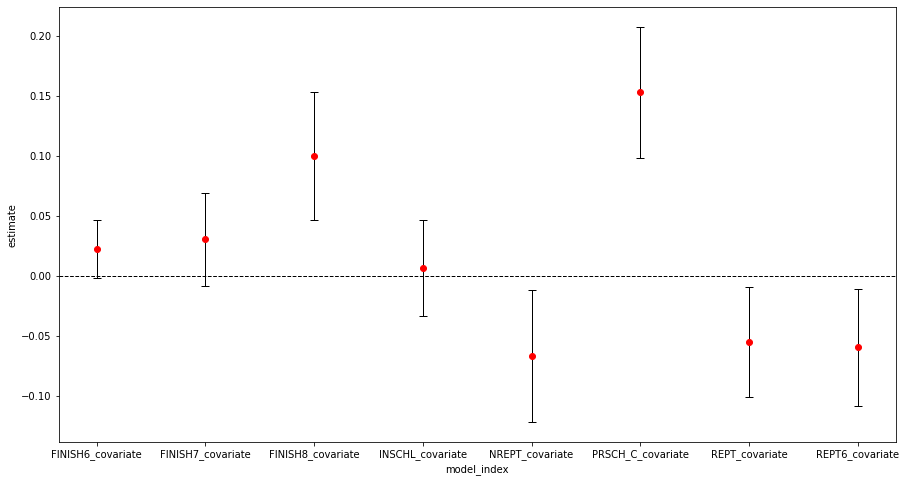

In [217]:
# 図2.4: 留年と進級の傾向
yerr = (regression_results_234["0.975]"] - regression_results_234["[0.025"]) / 2
plt.figure(figsize = (15, 8))
plt.errorbar(regression_results_234.index, regression_results_234["coef"], yerr = yerr, fmt = "ro", capsize = 4, ecolor = "black", linewidth = 1)
plt.axhline(y = 0, linestyle = "dashed", color = "black", linewidth = 1)
plt.ylabel("estimate")
plt.xlabel("model_index")

## 2.3.5 性別による効果差

In [218]:
# データ抽出
data_tbl4_bog95 = vouchers[(vouchers["BOG95SMP"] == 1) & (vouchers["TAB3SMPL"] == 1) & (vouchers["SCYFNSH"].notna()) & (vouchers["FINISH6"].notna()) & 
                           (vouchers["PRSCHA_1"].notna()) & (vouchers["REPT6"].notna()) & (vouchers["NREPT"].notna()) & (vouchers["INSCHL"].notna()) & 
                           (vouchers["FINISH7"].notna()) & (vouchers["PRSCH_C"].notna()) & (vouchers["FINISH8"].notna()) & (vouchers["PRSCHA_2"].notna()) & 
                           (vouchers["TOTSCYRS"].notna()) & (vouchers["REPT"].notna())][["VOUCH0", "SVY", "HSVISIT", "DJAMUNDI", "PHONE", "AGE", 
                                                                                         "STRATA1", "STRATA2", "STRATA3", "STRATA4", "STRATA5", "STRATA6", "STRATAMS", "DBOGOTA", "D1993", "D1995", "D1997", 
                                                                                         "DMONTH1", "DMONTH2", "DMONTH3", "DMONTH4", "DMONTH5", "DMONTH6", "DMONTH7", "DMONTH8", "DMONTH9", "DMONTH10", "DMONTH11", "DMONTH12", 
                                                                                         "SEX_MISS", "FINISH6", "FINISH7", "FINISH8", "REPT6", "REPT", "NREPT", "SEX2", "TOTSCYRS", "MARRIED", "HASCHILD", "HOURSUM", "WORKING3", "INSCHL", "PRSCH_C", "USNGSCH", "PRSCHA_1"]]
data_tbl4_bog95.head()

,VOUCH0,SVY,HSVISIT,DJAMUNDI,PHONE,AGE,STRATA1,STRATA2,STRATA3,STRATA4,STRATA5,STRATA6,STRATAMS,DBOGOTA,D1993,D1995,D1997,DMONTH1,DMONTH2,DMONTH3,DMONTH4,DMONTH5,DMONTH6,DMONTH7,DMONTH8,DMONTH9,DMONTH10,DMONTH11,DMONTH12,SEX_MISS,FINISH6,FINISH7,FINISH8,REPT6,REPT,NREPT,SEX2,TOTSCYRS,MARRIED,HASCHILD,HOURSUM,WORKING3,INSCHL,PRSCH_C,USNGSCH,PRSCHA_1
4,1.0,0.0,0.0,0.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5,0.0,0.0,0.0,0.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,0.0,0.0,0.0,0.0,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7,0.0,0.0,0.0,0.0,1.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
11,1.0,0.0,0.0,0.0,1.0,14.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### 女子生徒のみのデータでの回帰分析

In [219]:
# 女子生徒のデータだけ取り出す
regression_data = data_tbl4_bog95[data_tbl4_bog95["SEX2"] == 0]

In [220]:
# まとめて回帰分析を実行

# 各推定結果を格納するリストを用意
regression_results = []

# 被説明変数ごとに回帰を繰り返す
for y in formula_y:

  # 共変量を含まない場合
  regression_results.append(get_VOUCH0_regression_summary(regression_data, formula_x_base = formula_x_base, formula_x_covariate = None, formula_y = y))

  # 共変量を含む場合
  regression_results.append(get_VOUCH0_regression_summary(regression_data, formula_x_base = formula_x_base, formula_x_covariate = formula_x_covariate, formula_y = y))

In [221]:
# モデルの結果を整形
df_results_female = pd.concat(regression_results, axis = 1).T
df_results_female

,coef,std err,t,P>|t|,[0.025,0.975]
TOTSCYRS_base,0.1478,0.067,2.197,0.028,0.016,0.280
TOTSCYRS_covariate,0.0909,0.066,1.381,0.168,-0.038,0.220
INSCHL_base,0.0636,0.030,2.143,0.033,0.005,0.122
INSCHL_covariate,0.0347,0.028,1.237,0.217,-0.020,0.090
PRSCH_C_base,0.1852,0.040,4.664,0.000,0.107,0.263
PRSCH_C_covariate,0.1711,0.039,4.337,0.000,0.094,0.249
USNGSCH_base,0.5505,0.032,17.332,0.000,0.488,0.613
USNGSCH_covariate,0.5436,0.032,16.992,0.000,0.481,0.606
PRSCHA_1_base,0.0408,0.023,1.777,0.076,-0.004,0.086
PRSCHA_1_covariate,0.0229,0.023,1.011,0.312,-0.022,0.067


### 男子生徒のみのデータでの回帰分析

In [222]:
# 男子生徒のデータだけ取り出す
regression_data = data_tbl4_bog95[data_tbl4_bog95["SEX2"] == 1]

In [223]:
# まとめて回帰分析を実行

# 各推定結果を格納するリストを用意
regression_results = []

# 被説明変数ごとに回帰を繰り返す
for y in formula_y:

  # 共変量を含まない場合
  regression_results.append(get_VOUCH0_regression_summary(regression_data, formula_x_base = formula_x_base, formula_x_covariate = None, formula_y = y))

  # 共変量を含む場合
  regression_results.append(get_VOUCH0_regression_summary(regression_data, formula_x_base = formula_x_base, formula_x_covariate = formula_x_covariate, formula_y = y))

In [224]:
# モデルの結果を整形
df_results_male = pd.concat(regression_results, axis = 1).T
df_results_male.head()

,coef,std err,t,P>|t|,[0.025,0.975]
TOTSCYRS_base,-0.0304,0.080,-0.380,0.704,-0.188,0.127
TOTSCYRS_covariate,-0.0286,0.078,-0.366,0.714,-0.182,0.125
INSCHL_base,-0.0259,0.031,-0.825,0.410,-0.088,0.036
INSCHL_covariate,-0.0195,0.030,-0.658,0.511,-0.078,0.039
PRSCH_C_base,0.1351,0.040,3.350,0.001,0.056,0.214


### 図2.5: 私立学校への入学と奨学金の利用

In [225]:
# df_results_femaleとdf_results_maleから図作成に必要な結果のみを抽出
female_fig25 = df_results_female.loc[["PRSCHA_1_covariate", "USNGSCH_covariate"]]
print("[female]\n", female_fig25)
male_fig25 = df_results_male.loc[["PRSCHA_1_covariate", "USNGSCH_covariate"]]
print("\n[male]\n", male_fig25)

[female]
                       coef  std err       t  P>|t|  [0.025  0.975]
PRSCHA_1_covariate  0.0229    0.023   1.011  0.312  -0.022   0.067
USNGSCH_covariate   0.5436    0.032  16.992  0.000   0.481   0.606

[male]
                       coef  std err       t  P>|t|  [0.025  0.975]
PRSCHA_1_covariate  0.0902    0.025   3.555    0.0   0.040   0.140
USNGSCH_covariate   0.4677    0.033  14.159    0.0   0.403   0.533


(-1.0, 2.0)

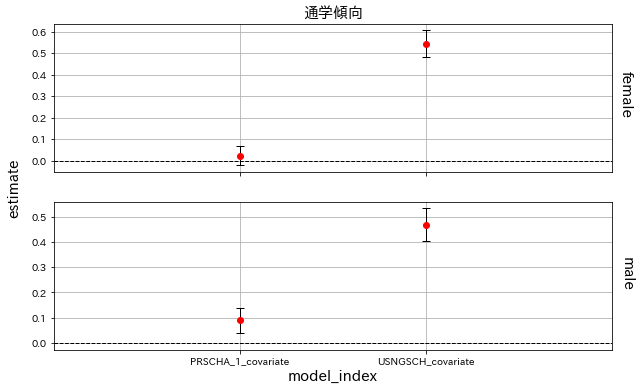

In [317]:
# 描画
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (10, 6))

# female
yerr_female = (female_fig25["0.975]"] - female_fig25["[0.025"]) / 2
ax1.errorbar(female_fig25.index, female_fig25["coef"], yerr = yerr_female, fmt = "ro", capsize = 4, ecolor = "black", linewidth = 1)
ax1.axhline(y = 0, linestyle = "dashed", color = "black", linewidth = 1)
ax1.set_title("通学傾向", size = 15)
ax1.grid(True)

# male
yerr_male = (male_fig25["0.975]"] - male_fig25["[0.025"]) / 2
ax2.errorbar(male_fig25.index, male_fig25["coef"], yerr = yerr_male, fmt = "ro", capsize = 4, ecolor = "black", linewidth = 1)
ax2.axhline(y = 0, linestyle = "dashed", color = "black", linewidth = 1)
ax2.set_xlabel("model_index", size = 15)
ax2.grid(True)

# labels
fig.text(0.06, 0.5, "estimate", va = "center", rotation = "vertical", size = 15)
fig.text(0.91, 0.67, "female", rotation = 270, size = 15)
fig.text(0.91, 0.27, "male", rotation = 270, size = 15)
plt.xlim(-1, 2)

### 図2.6: 留年と進級の傾向

In [318]:
# df_results_femaleとdf_results_maleから図作成に必要な結果のみを抽出
female_fig26 = df_results_female.loc[["FINISH6_covariate", "FINISH7_covariate", "FINISH8_covariate", "INSCHL_covariate", "NREPT_covariate", "PRSCH_C_covariate", "REPT_covariate", "REPT6_covariate", "TOTSCYRS_covariate"]]
print("[female]\n", female_fig26)
male_fig26 = df_results_male.loc[["FINISH6_covariate", "FINISH7_covariate", "FINISH8_covariate", "INSCHL_covariate", "NREPT_covariate", "PRSCH_C_covariate", "REPT_covariate", "REPT6_covariate", "TOTSCYRS_covariate"]]
print("\n[male]\n", male_fig26)

[female]
                       coef  std err      t  P>|t|  [0.025  0.975]
FINISH6_covariate   0.0317    0.014  2.281  0.023   0.004   0.059
FINISH7_covariate   0.0411    0.025  1.626  0.105  -0.009   0.091
FINISH8_covariate   0.1047    0.037  2.865  0.004   0.033   0.177
INSCHL_covariate    0.0347    0.028  1.237  0.217  -0.020   0.090
NREPT_covariate    -0.0313    0.035 -0.905  0.366  -0.099   0.037
PRSCH_C_covariate   0.1711    0.039  4.337  0.000   0.094   0.249
REPT_covariate     -0.0290    0.032 -0.901  0.368  -0.092   0.034
REPT6_covariate    -0.0362    0.031 -1.155  0.249  -0.098   0.025
TOTSCYRS_covariate  0.0909    0.066  1.381  0.168  -0.038   0.220

[male]
                       coef  std err      t  P>|t|  [0.025  0.975]
FINISH6_covariate   0.0144    0.020  0.734  0.463  -0.024   0.053
FINISH7_covariate   0.0264    0.031  0.866  0.387  -0.034   0.086
FINISH8_covariate   0.0950    0.040  2.368  0.018   0.016   0.174
INSCHL_covariate   -0.0195    0.030 -0.658  0.511  -0.078

Text(0.905, 0.27, 'male')

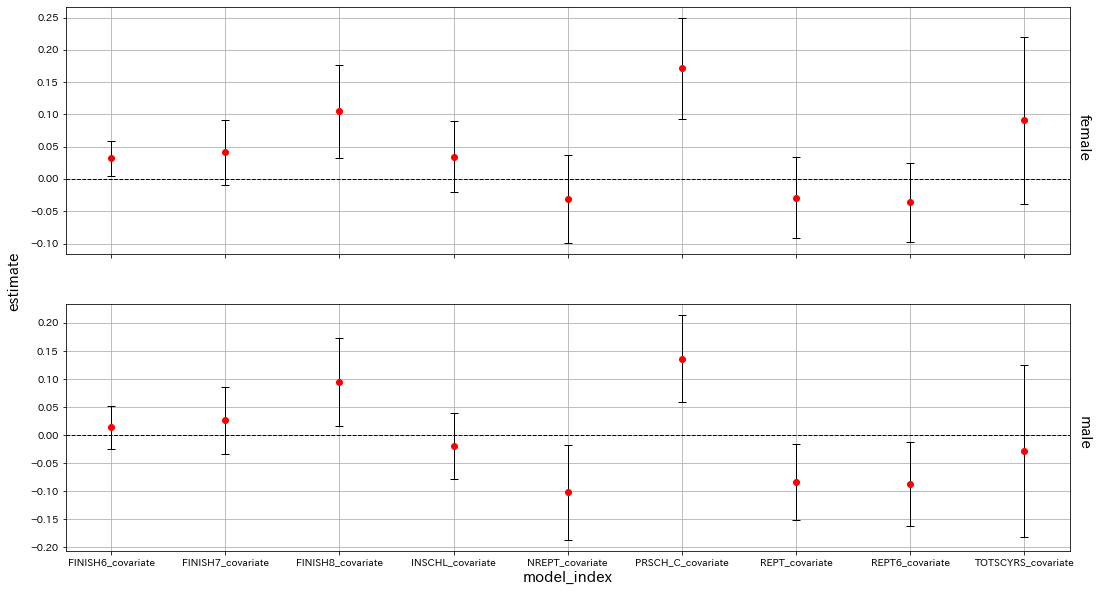

In [327]:
# 描画
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (18, 10))

# female
yerr_female = (female_fig26["0.975]"] - female_fig26["[0.025"]) / 2
ax1.errorbar(female_fig26.index, female_fig26["coef"], yerr = yerr_female, fmt = "ro", capsize = 4, ecolor = "black", linewidth = 1)
ax1.axhline(y = 0, linestyle = "dashed", color = "black", linewidth = 1)
ax1.grid(True)

# male
yerr_male = (male_fig26["0.975]"] - male_fig26["[0.025"]) / 2
ax2.errorbar(male_fig26.index, male_fig26["coef"], yerr = yerr_male, fmt = "ro", capsize = 4, ecolor = "black", linewidth = 1)
ax2.axhline(y = 0, linestyle = "dashed", color = "black", linewidth = 1)
ax2.set_xlabel("model_index", size = 15)
ax2.grid(True)

# labels
fig.text(0.08, 0.5, "estimate", va = "center", rotation = "vertical", size = 15)
fig.text(0.905, 0.67, "female", rotation = 270, size = 15)
fig.text(0.905, 0.27, "male", rotation = 270, size = 15)
#plt.xlim(-1, 2)

### 図2.7: 労働時間の傾向

In [330]:
# df_results_femaleとdf_results_maleから図作成に必要な結果のみを抽出
female_fig27 = df_results_female.loc[["HOURSUM_covariate"]]
print("[female]\n", female_fig27)
male_fig27 = df_results_male.loc[["HOURSUM_covariate"]]
print("\n[male]\n", male_fig27)

[female]
                      coef  std err      t  P>|t|  [0.025  0.975]
HOURSUM_covariate -2.1158    0.685 -3.089  0.002  -3.461   -0.77

[male]
                      coef  std err      t  P>|t|  [0.025  0.975]
HOURSUM_covariate -0.6376    1.068 -0.597  0.551  -2.736   1.461


Text(0.5, 0.05, 'model_index')

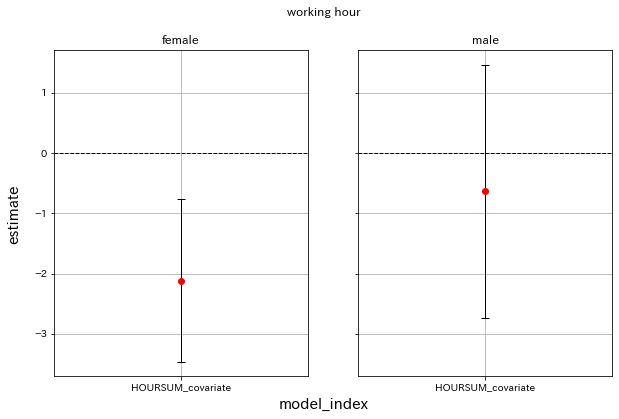

In [342]:
# 描画
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharey = True, figsize = (10, 6))

# female
yerr_female = (female_fig27["0.975]"] - female_fig27["[0.025"]) / 2
ax1.errorbar(female_fig27.index, female_fig27["coef"], yerr = yerr_female, fmt = "ro", capsize = 4, ecolor = "black", linewidth = 1)
ax1.axhline(y = 0, linestyle = "dashed", color = "black", linewidth = 1)
ax1.set_title("female")
ax1.grid(True)

# male
yerr_male = (male_fig27["0.975]"] - male_fig27["[0.025"]) / 2
ax2.errorbar(male_fig27.index, male_fig27["coef"], yerr = yerr_male, fmt = "ro", capsize = 4, ecolor = "black", linewidth = 1)
ax2.axhline(y = 0, linestyle = "dashed", color = "black", linewidth = 1)
ax2.set_title("male")
ax2.grid(True)

# labels
fig.suptitle("working hour")
fig.text(0.06, 0.5, "estimate", va = "center", rotation = "vertical", size = 15)
fig.text(0.5, 0.05, "model_index", ha = "center", size = 15)